Partition data set

In [8]:
import os
import random
import shutil
from tqdm import tqdm

# Defines the dataset folder path.
dataset_folder = 'data/origin'

# Defines the path of the partitioned dataset folder.
new_dataset_folder = 'data/building'

try:
    shutil.rmtree('data/building')
except Exception as e:
    print(e)

# Define partition ratios
train_ratio = 0.8  # Training set ratio
val_ratio = 0.1    # Validation set ratio
test_ratio = 0.1   # Test set ratio

# Get the list of subclasses in the dataset folder
subclasses = os.listdir(dataset_folder)

# Create a new dataset folder
os.makedirs(new_dataset_folder, exist_ok=True)

# Create train, val, and test folders
train_folder = os.path.join(new_dataset_folder, 'train')
val_folder = os.path.join(new_dataset_folder, 'val')
test_folder = os.path.join(new_dataset_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each subclass
for subclass in tqdm(subclasses):
    subclass_folder = os.path.join(dataset_folder, subclass)
    if os.path.isdir(subclass_folder):
        # Get all image files in the subclass
        image_files = [f for f in os.listdir(subclass_folder) if f.endswith('.jpg')]

        # Shuffle the image file list randomly
        random.shuffle(image_files)

        # Calculate the number of samples based on partition ratios
        num_samples = len(image_files)
        num_train = int(train_ratio * num_samples)
        num_val = int(val_ratio * num_samples)

        # Partition the dataset
        train_files = image_files[:num_train]
        val_files = image_files[num_train:num_train + num_val]
        test_files = image_files[num_train + num_val:]

        # Copy the image files to the respective folders
        for file in train_files:
            src_path = os.path.join(subclass_folder, file)
            dest_path = os.path.join(train_folder, subclass, file)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copyfile(src_path, dest_path)

        for file in val_files:
            src_path = os.path.join(subclass_folder, file)
            dest_path = os.path.join(val_folder, subclass, file)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copyfile(src_path, dest_path)

        for file in test_files:
            src_path = os.path.join(subclass_folder, file)
            dest_path = os.path.join(test_folder, subclass, file)
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            shutil.copyfile(src_path, dest_path)

[WinError 3] 系统找不到指定的路径。: 'data/building'


100%|██████████| 23/23 [00:14<00:00,  1.64it/s]


Information about the images in the statistical data set


In [9]:
import os
import glob
import pandas as pd

def count_images_per_class(path):
    class_counts = {}
    class_folders = glob.glob(os.path.join(path, '*'))

    for class_folder in class_folders:
        class_name = os.path.basename(class_folder)
        image_files = glob.glob(os.path.join(class_folder, '*.jpg'))
        if class_name in class_counts:
            class_counts[class_name] += len(image_files)
        else:
            class_counts[class_name] = len(image_files)

    return class_counts

# Specify the dataset path
dataset_path = 'data/building'

# Count the number of images per class in the training, validation, and test sets
train_counts = count_images_per_class(os.path.join(dataset_path, 'train'))
val_counts = count_images_per_class(os.path.join(dataset_path, 'val'))
test_counts = count_images_per_class(os.path.join(dataset_path, 'test'))

# Combine the count results
combined_counts = {}
for class_name in set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys())):
    combined_counts[class_name] = {
        'Train Count': train_counts.get(class_name, 0),
        'Validation Count': val_counts.get(class_name, 0),
        'Test Count': test_counts.get(class_name, 0)
    }

# Build individual class count reports
train_report = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count'])
train_report.index.name = 'Class'
train_report.reset_index(inplace=True)

val_report = pd.DataFrame.from_dict(val_counts, orient='index', columns=['Validation Count'])
val_report.index.name = 'Class'
val_report.reset_index(inplace=True)

test_report = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count'])
test_report.index.name = 'Class'
test_report.reset_index(inplace=True)

# Build the combined class count report
combined_report = pd.DataFrame.from_dict(combined_counts, orient='index')
combined_report.index.name = 'Class'
combined_report.reset_index(inplace=True)

# Print the combined class count report
print(combined_report)

train_total = sum(train_counts.values())
val_total = sum(val_counts.values())
test_total = sum(test_counts.values())

print(f'train_total: {train_total}   val_total:{val_total}   test_total:{test_total}')
total = train_total + val_total + test_total
train_ratio = train_total / total
val_ratio = val_total / total
test_ratio = test_total / total

print("Train set ratio: {:.2%}, Validation set ratio: {:.2%}, Test set ratio: {:.2%}".format(train_ratio, val_ratio, test_ratio))

                        Class  Train Count  Validation Count  Test Count
0              B10-L02-Middle          166                20          22
1   B11-L02-SouthEast-DaVinci          171                21          22
2       B02-L05-North-Library          128                16          17
3         B10-L02-WestClasses          336                42          42
4                 B02-Outside          182                22          24
5      B06-Outside-UTSHousing          130                16          17
6          B10-L02-WestStairs           89                11          12
7      B2L7 Library Reception           31                 3           5
8            B01-L00-WestGate          195                24          25
9                  B10-L02-ID           41                 5           6
10               B2L6 library           26                 3           4
11           Building2 Ground           42                 5           6
12            library level 5           42         

Define the network

In [10]:

# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from torch.autograd import Variable
from torchvision import transforms
from tqdm import tqdm
import os

import warnings

warnings.filterwarnings("ignore")
import torchvision.models as models
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import clear_output
from PIL import Image,ImageFile


def make_dir(path):
    import os
    dir = os.path.exists(path)
    if not dir:
        os.makedirs(path)


def write_string_to_file(string, file_path):  # Write a string to a file
    with open(file_path, "a+", encoding='utf-8') as f:
        f.write(string + '\n')





def plot_confusion_matrix(model, test_loader, class_names):  # Draw confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.rcParams['font.sans-serif'] = ['SimSun']  

    # Test
    correct = 0
    total = 0
    model.eval()
    all_predictions = []
    all_labels = []

    for (images, labels) in tqdm(test_loader):
        images = Variable(images)
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        acc_test = (100 * correct / total).item()
        acc_test = round(acc_test, 2)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print(f'Acc_test: {acc_test}%')

    cm = confusion_matrix(all_labels, all_predictions)
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()


def plot(x, y, title):
    from matplotlib import pyplot as plt  
    plt.figure()
    plt.plot(x, y)
    plt.title(f"{title} curve")
    plt.xlabel("Epoch")
    plt.ylabel(f"{title}")
    plt.plot(x, y, color='red')
    plt.savefig(f'{title}.jpg', dpi=300)
    plt.show()


def read_txt_to_data_list(txt_name, lie=1):  # Read the column data in the TxT document as a list list.
    filehandle = open(txt_name, "r")
    strings = filehandle.readlines()
    filehandle.close()
    list = []
    for string in strings:
        list_temp_string = string.split('\t')
        try:
            data = float(list_temp_string[lie])

        except:
            data = list_temp_string[lie]

        list.append(data)
    return list


Set the superparameter of the network

In [14]:
if __name__ == '__main__':
    with open('results.txt', "w+", encoding='utf-8') as f:  # Empty this result file at the beginning.
        f.write('')

    batch_size = 16
    lr = 0.00001
    num_classes = 24
    epochs = 50
    num_workers = 8
    model_name = 'GoogLeNet'
    dataset_name = 'building'

    model = models.googlenet(pretrained=True).cuda()

    model.fc = nn.Linear(in_features=1024, out_features=num_classes).cuda()
    # model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    save_dir = 'results'
    make_dir(save_dir)

Read data set

In [15]:
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224),
        transforms.ToTensor(),  # 注意这里将ToTensor放在Compose中的同一个列表中
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = dsets.ImageFolder(root=f'./data/{dataset_name}/train',
                                      transform=transform)
    val_dataset = dsets.ImageFolder(root=f'./data/{dataset_name}/val',
                                    transform=transform)
    test_dataset = dsets.ImageFolder(root=f'./data/{dataset_name}/test',
                                     transform=transform)

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              shuffle=False)


Network training

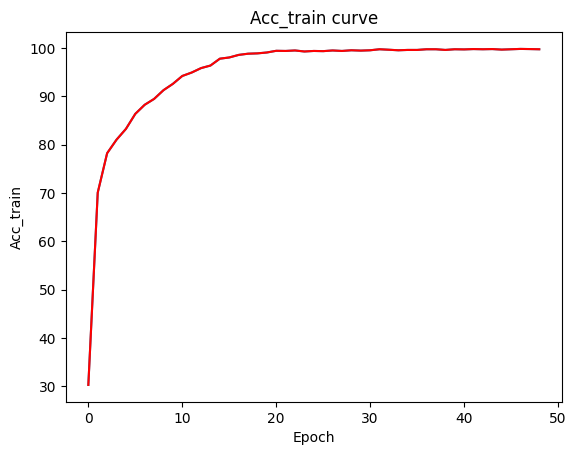

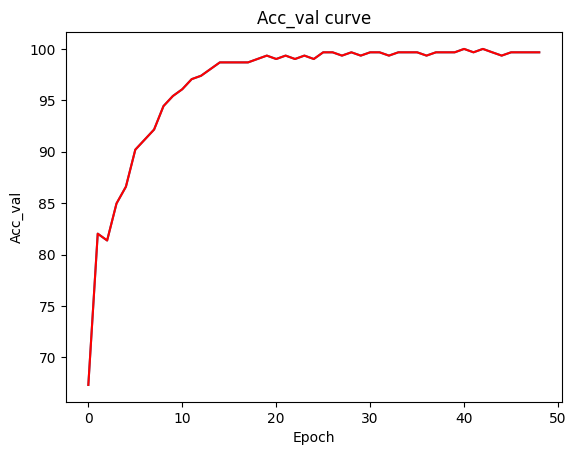

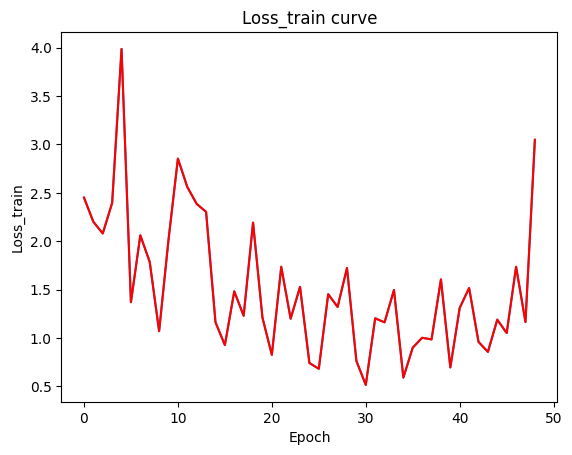

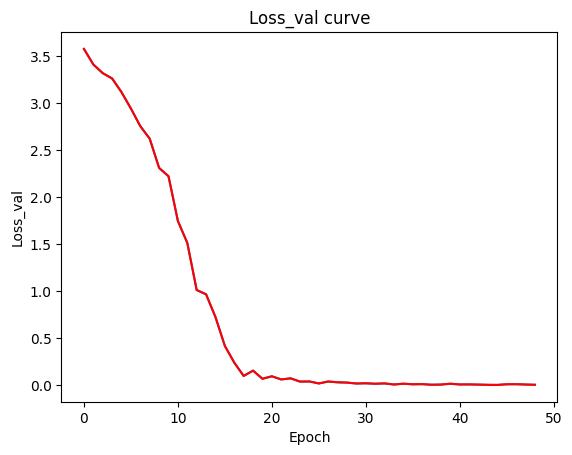

100%|██████████| 50/50 [15:22<00:00, 18.46s/it]


In [16]:
    correct = 0
    total = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        for i, (images, labels) in enumerate(train_loader):  # 网络训练
            images = Variable(images)
            labels = Variable(labels)
            images = images.cuda()
            labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss_train = criterion(outputs, labels)
            loss_train.backward()
            optimizer.step()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum()
            print("Epoch [%d/%d], Iter [%d/%d] Train Loss: %.4f" % (
                epoch + 1, epochs, (i + 1) * batch_size, len(train_dataset), loss_train.item()))
            acc_train = (100 * correct / total).item()
            acc_train = round(acc_train, 2)
            print(f'Acc_train:{acc_train}%')
            if (i + 1) % 5 == 0:
                print("Epoch [%d/%d], Iter [%d/%d] Train Loss: %.4f" % (
                epoch + 1, epochs, (i + 1) * batch_size, len(train_dataset), loss_train.item()))

        correct = 0
        total = 0
        model.eval()  # 进行验证
        for i, (images, labels) in enumerate(val_loader):  # 网络验证
            images = Variable(images)
            labels = Variable(labels)
            images = images.cuda()
            labels = labels.cuda()
            # Forward
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            print("Epoch [%d/%d], Iter [%d/%d] Val Loss: %.4f" % (
                epoch + 1, epochs, (i + 1) * batch_size, len(val_dataset), loss_val.item()))

        acc_val = (100 * correct / total).item()
        acc_val = round(acc_val, 2)
        clear_output(wait=True)
        print(f'Acc_val:{acc_val}%')

        # 每个周期画一次图
        txt_name = 'results.txt'
        epoch_plot = read_txt_to_data_list(txt_name, lie=0)
        Acc_train = read_txt_to_data_list(txt_name, lie=1)
        Acc_val = read_txt_to_data_list(txt_name, lie=2)
        Loss_train = read_txt_to_data_list(txt_name, lie=3)
        Loss_val = read_txt_to_data_list(txt_name, lie=4)

        plot(epoch_plot, Acc_train, 'Acc_train')
        plot(epoch_plot, Acc_val, 'Acc_val')
        plot(epoch_plot, Loss_train, "Loss_train")
        plot(epoch_plot, Loss_val, "Loss_val")

        torch.save(model, f'./{save_dir}/{model_name}-epoch_{epoch}-acc_{acc_val}.pth')
        write_string_to_file(f'{epoch}\t{acc_train}\t{acc_val}\t{loss_train}\t{loss_val}', 'results.txt')
        # write_string_to_file(f'{epoch}\t{acc_val}\t{loss_val}', 'results_val.txt')

        # Decaying Learning Rate
        if (epoch + 1) % 20 == 0:
            lr /= 3
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Test and draw confusion matrix.

Acc_test: 99.7%


100%|██████████| 21/21 [00:02<00:00,  7.85it/s]


Acc_test: 99.7%


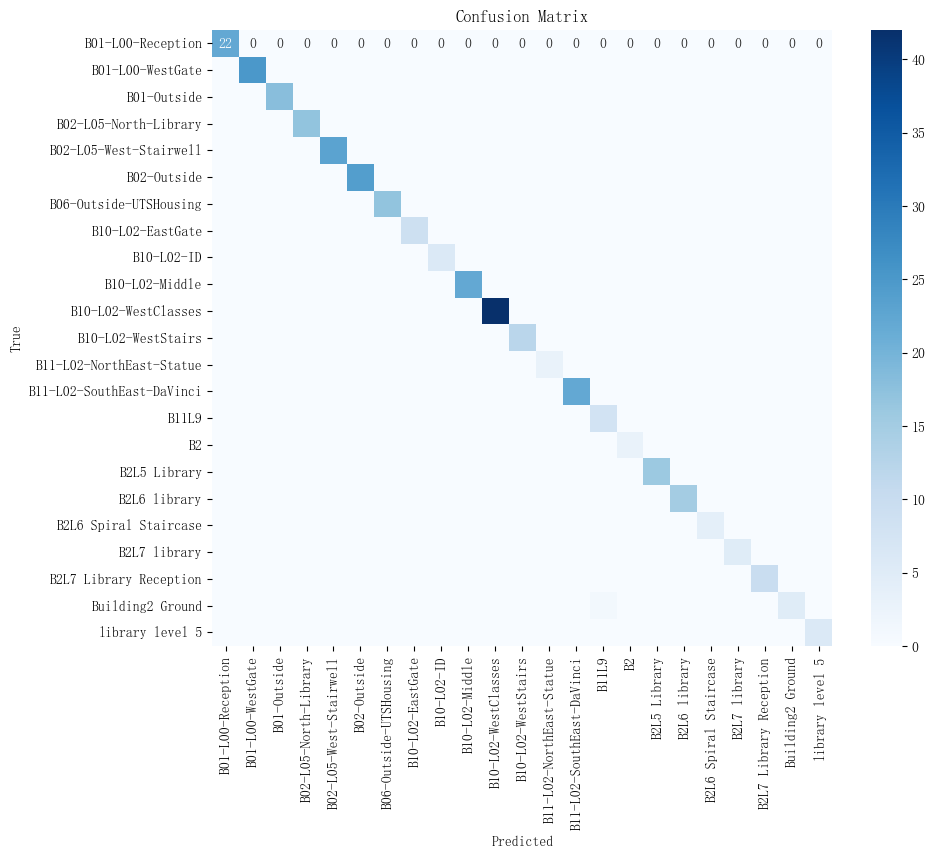

In [17]:
    # Test
    correct = 0
    total = 0
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images)
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        acc_test = (100 * correct / total).item()
        acc_test = round(acc_test, 2)
    print(f'Acc_test: {acc_test}%')
    torch.save(model, f'./{save_dir}/{model_name}_last.pth')

    # model = torch.load(f'{save_dir}/{model_name}_all.pth')
#     class_names = os.listdir('data/scene/test')
    class_names = os.listdir(f'data/{dataset_name}/test')

    plot_confusion_matrix(model, test_loader, class_names)  # 绘制混淆矩阵



Get the parameters of the network model.


In [18]:
    from torchsummary import summary

    # 输入示例数据
    input_size = (3, 224, 224)
    input_data = torch.randn(1, *input_size)

    # 打印模型的参数信息
    summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

Predicting a single picture 
You only need to modify the image path when using it.

In [19]:
import os
import torch
from torchvision import transforms
from PIL import Image
import time


def predict_single_image(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)

    return predicted.item()


# image_path = 'data/building/train/B01-L00-WestGate/1.jpg'
# image_path = 'data/building/val/B01-L00-Reception/9.jpg'
image_path = 'data/origin/B01-L00-Reception/0.jpg'

# Load the model

classname_list = os.listdir('data/building/val/')
time_start = time.time()

model = torch.load('results/GoogLeNet_last.pth')


predicted_class = predict_single_image(model, image_path)
print("Predicted class:", predicted_class)
print("The current location is:", classname_list[predicted_class])

time_end = time.time()
time_cost = time_end - time_start
print('Time cost = %fs' % (time_cost))
    
    

Predicted class: 0
The current location is: B01-L00-Reception
Time cost = 0.158496s
